In [3]:
# i'm using kaggle notebook, the next line downloads the data from dryad
# !wget --user-agent="Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.159 Safari/537.36" -O data.csv 'https://datadryad.org/stash/downloads/file_stream/67671'

In [4]:
import pandas as pd
import scanpy as sc
import anndata as ad
import squidpy as sq
import scipy.sparse as sp
from scipy.cluster import hierarchy as sch
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


# laoding the data

In [5]:

data = pd.read_csv('data.csv', index_col=0)

In [6]:
# extracting gene count matrix which begins from column 8
gene_counts_df = data.iloc[:,8:]
gene_counts_df = gene_counts_df.reset_index(drop=True)
gene_counts_df

,Ace2,Adora2a,Aldh1l1,Amigo2,Ano3,Aqp4,Ar,Arhgap36,Avpr1a,Avpr2,...,Penk,Scg2,Sln,Sst,Tac1,Tac2,Th,Trh,Ucn3,Vgf
0,0.0,1.638275,21.299750,0.000000,1.638275,16.382010,0.000000,0.000000,0.000000,0.000000,...,0.133016,0.000000,0.865263,0.002977,0.054826,0.008934,0.000000,0.000000,0.000000,0.000000
1,0.0,0.000000,1.578873,0.000000,0.789452,0.789452,1.578873,0.789452,0.000000,0.000000,...,0.000000,0.000000,0.277939,0.868702,0.580957,0.010079,0.000000,0.000000,0.000000,0.000000
2,0.0,0.000000,2.701349,5.402654,0.000000,0.000000,0.000000,2.701349,0.000000,0.000000,...,0.213939,0.000000,0.377907,0.049332,0.084898,0.008951,0.000000,0.000000,0.000000,0.000000
3,0.0,0.000000,1.845116,0.922560,0.000000,0.922560,0.922560,0.922560,0.000000,0.000000,...,0.050882,0.089038,0.000000,0.000000,0.001530,0.031364,0.000000,0.000000,0.000000,0.001138
4,0.0,0.000000,6.352415,0.000000,0.000000,3.176188,3.176188,3.176188,0.000000,0.000000,...,1.250661,0.159618,0.211159,0.000000,0.087730,0.000000,0.000000,0.000000,0.000000,0.029419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1027843,0.0,0.000000,0.000000,1.326751,0.000000,0.000000,5.307104,1.326751,1.326751,1.326751,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.040998,0.000000,0.000000,0.024618,0.000000
1027844,0.0,0.000000,2.663616,5.327177,0.000000,0.000000,2.663616,31.960971,0.000000,0.000000,...,0.000000,0.852081,0.000000,0.695548,0.000000,0.024392,0.475944,0.000000,0.000000,0.000000
1027845,0.0,0.000000,2.076664,2.076664,0.000000,0.000000,2.076664,0.000000,2.076664,0.000000,...,0.058011,0.000000,0.000000,0.000000,0.000000,0.061898,0.000000,0.000000,0.000000,0.000000
1027846,0.0,0.000000,14.513150,0.000000,0.000000,0.000000,0.000000,14.513150,0.000000,0.000000,...,0.000000,0.326172,0.000000,0.000000,0.000000,0.063518,0.000000,0.000000,0.000000,0.000000


In [7]:
#list(adata.var_names)
# extracting blank genes and making sure only 5 blank found as mentioned in moffit supplementary material 
blank_genes =[]
for i in gene_counts_df.columns:
    if 'Blank' in i :
        blank_genes.append(i)
blank_genes

['Blank_1', 'Blank_2', 'Blank_3', 'Blank_4', 'Blank_5']

In [9]:
# droping blank_genes
# Remove the specified genes from the gene count matrix
# and extracting gene names and assign it to gene_metadata_df
keep_genes = [gene for gene in gene_counts_df.columns if gene not in blank_genes]
gene_counts_df = gene_counts_df[keep_genes]
gene_metadata_df = pd.DataFrame(index=gene_counts_df.columns.tolist())
gene_counts_df = gene_counts_df[keep_genes]
gene_metadata_df = gene_metadata_df.loc[keep_genes]


In [10]:
# extrating meta data which ends at column 8
cell_meta_data_df = data.iloc[:,:8]

In [27]:
# creating anndata object
adata = sc.AnnData(X=gene_counts_df.values, obs=cell_meta_data_df, var=gene_metadata_df)

In [28]:
# notice that we have 156 genes and moffit identified 155 
adata

AnnData object with n_obs × n_vars = 1027848 × 156
    obs: 'Animal_ID', 'Animal_sex', 'Behavior', 'Bregma', 'Centroid_X', 'Centroid_Y', 'Cell_class', 'Neuron_cluster_ID'

# subset of the requied Bregma tissue sections -0.04, -0.09, -0.14, -0.19, and -0.24 mm

In [29]:
# identifying 'spatial' inside adata.obsm
spatial_cell_coordinates = cell_meta_data_df[['Centroid_X', 'Centroid_Y']].values
adata.obsm['spatial'] = np.transpose(spatial_cell_coordinates.transpose())

In [30]:
# Subset the AnnData object based on the required Bregma sections
required_sections = (
    (adata.obs['Bregma'] == -0.04) |
    (adata.obs['Bregma'] == -0.09) |
    (adata.obs['Bregma'] == -0.14) |
    (adata.obs['Bregma'] == -0.19) |
    (adata.obs['Bregma'] == -0.24)
)

adata = adata[required_sections]
# filter all animal exept animal 1
adata=adata[adata.obs['Animal_ID']==1]
# removing cells that are ammbiguous
adata=adata[adata.obs['Cell_class']!='Ambiguous']

In [31]:
# making sure we subset animal 1 and the required tissue sections
print((adata.obs['Animal_sex'].value_counts(),adata.obs['Bregma'].value_counts()))


(Animal_sex
Female    28317
Name: count, dtype: int64, Bregma
-0.14    5926
-0.19    5803
-0.09    5557
-0.24    5543
-0.04    5488
Name: count, dtype: int64)


In [32]:
adata

View of AnnData object with n_obs × n_vars = 28317 × 156
    obs: 'Animal_ID', 'Animal_sex', 'Behavior', 'Bregma', 'Centroid_X', 'Centroid_Y', 'Cell_class', 'Neuron_cluster_ID'
    obsm: 'spatial'

# QC

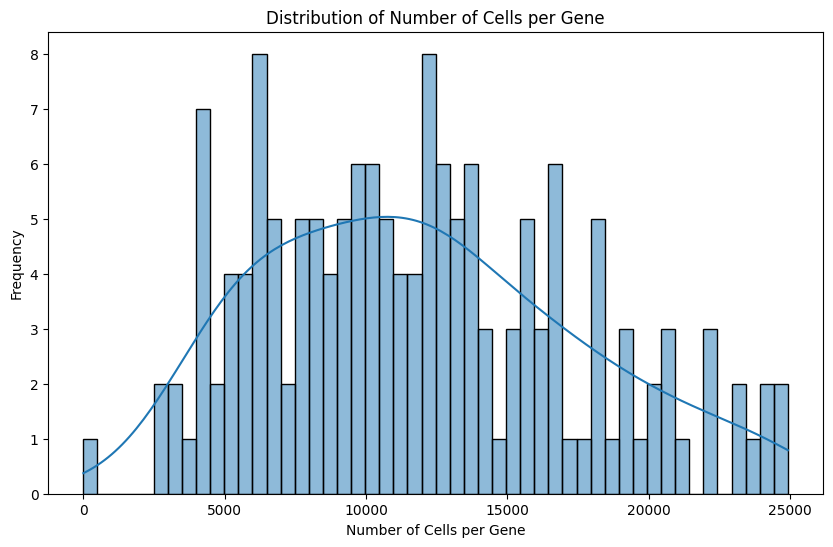

In [33]:
# Calculate number of cells per gene
cells_per_gene = (adata.X > 0).sum(axis=0)


# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(cells_per_gene, bins=50, kde=True)
plt.xlabel('Number of Cells per Gene')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Cells per Gene')
plt.show()


In [34]:
sc.pp.filter_genes(adata, min_cells=3, inplace=True)
sc.pp.filter_cells(adata, min_counts=1, inplace=True)
# enuring we don't have empty cells

/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:282: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


In [35]:
# notice that we now have 155 genes as mentioned
adata

AnnData object with n_obs × n_vars = 28317 × 155
    obs: 'Animal_ID', 'Animal_sex', 'Behavior', 'Bregma', 'Centroid_X', 'Centroid_Y', 'Cell_class', 'Neuron_cluster_ID', 'n_counts'
    var: 'n_cells'
    obsm: 'spatial'

<Axes: title={'center': 'Unique transcripts per cell'}, xlabel='n_genes_by_counts', ylabel='Count'>

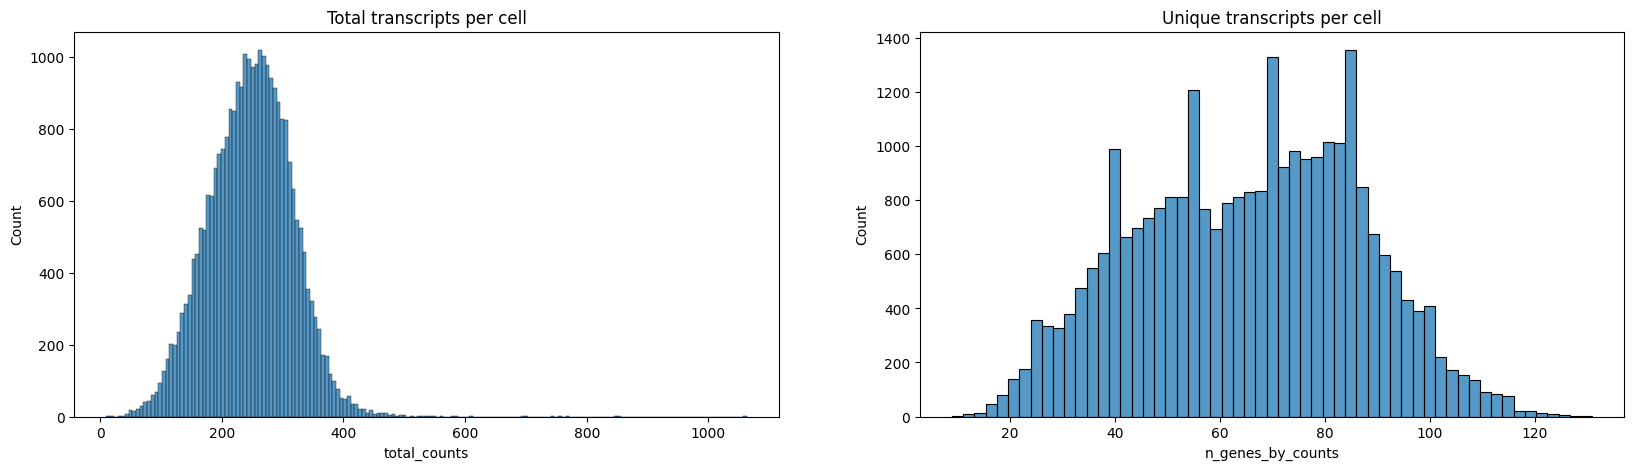

In [36]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

axs[0].set_title("Total transcripts per cell")
sns.histplot(
    adata.obs["total_counts"],
    kde=False,
    ax=axs[0],
)

axs[1].set_title("Unique transcripts per cell")
sns.histplot(
    adata.obs["n_genes_by_counts"],
    kde=False,
    ax=axs[1],
)

# normalization

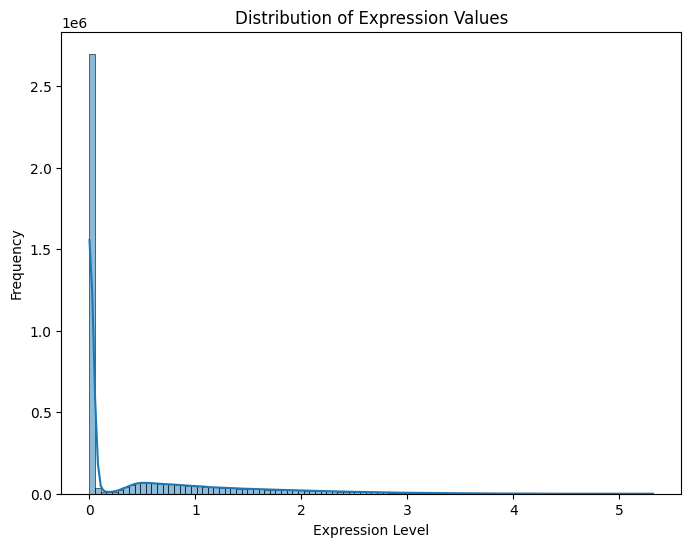

In [39]:
# Plot the distribution of expression values
plt.figure(figsize=(8, 6))
sns.histplot(adata.X.flatten(), bins=100, kde=True)
plt.xlabel("Expression Level")
plt.ylabel("Frequency")
plt.title("Distribution of Expression Values")
plt.show()


In [38]:
sc.pp.normalize_total(adata, inplace=True) # Normalize counts per cell
sc.pp.log1p(adata) # Logarithmize the data matrix
# sc.pp.scale(adata) # we dont need to sscale the data

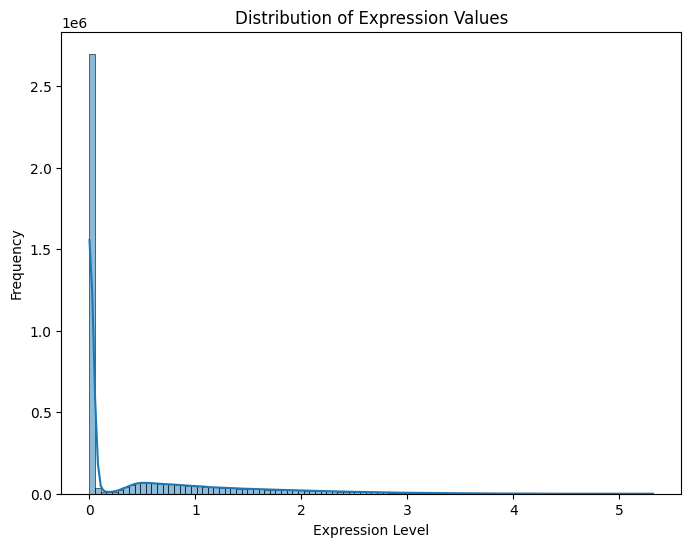

In [40]:
# Plot the distribution of expression values
plt.figure(figsize=(8, 6))
sns.histplot(adata.X.flatten(), bins=100, kde=True)
plt.xlabel("Expression Level")
plt.ylabel("Frequency")
plt.title("Distribution of Expression Values")
plt.show()

# notice that the data don't need scaling

<Axes: title={'center': 'Unique transcripts per cell'}, xlabel='n_genes_by_counts', ylabel='Count'>

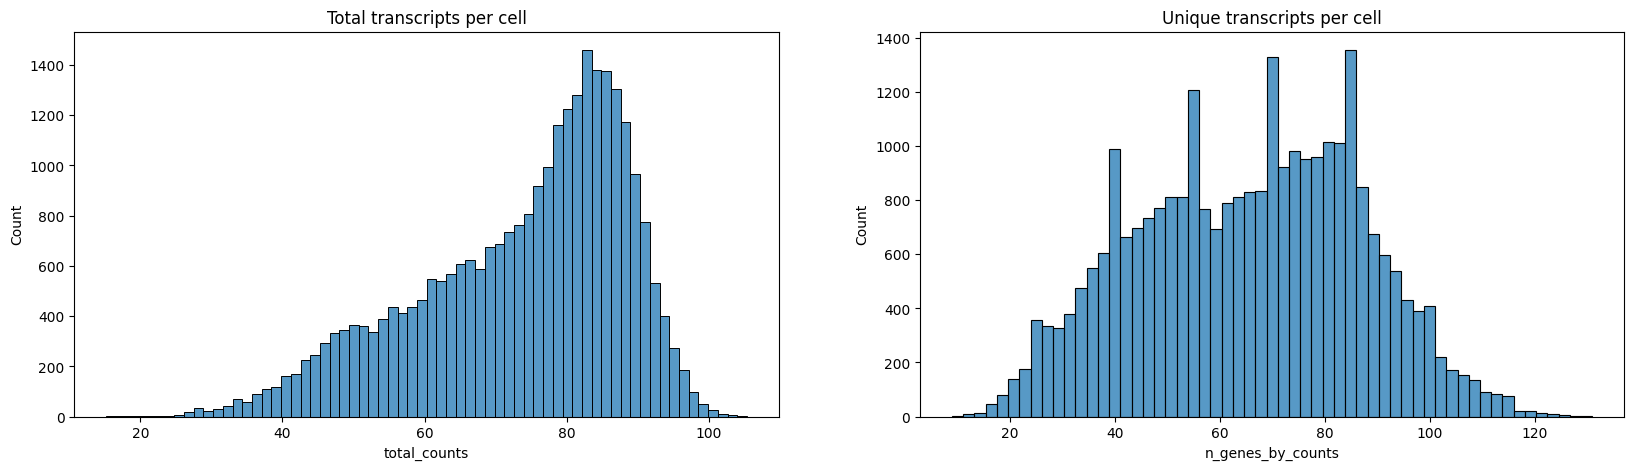

In [41]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

axs[0].set_title("Total transcripts per cell")
sns.histplot(
    adata.obs["total_counts"],
    kde=False,
    ax=axs[0],
)

axs[1].set_title("Unique transcripts per cell")
sns.histplot(
    adata.obs["n_genes_by_counts"],
    kde=False,
    ax=axs[1],
)

... storing 'Animal_sex' as categorical
... storing 'Behavior' as categorical
... storing 'Cell_class' as categorical
... storing 'Neuron_cluster_ID' as categorical


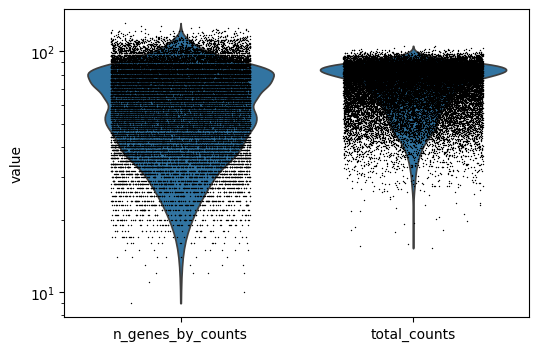

In [42]:
fig, axs = plt.subplots(1, 1, figsize=(6, 4))
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'], jitter=0.3, stripplot=True, log=True, ax=axs)

# preprocessing

In [43]:
def BasicScanpyPreprocessing(adata, resolution=None, n_comps=50):
    sc.pp.pca(adata, n_comps=n_comps)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    sc.tl.leiden(adata, key_added="Leiden",resolution=resolution)
    return adata

In [44]:
BasicScanpyPreprocessing(adata, resolution=0.65)

/tmp/ipykernel_36/2969792651.py:5: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, key_added="Leiden",resolution=resolution)


AnnData object with n_obs × n_vars = 28317 × 155
    obs: 'Animal_ID', 'Animal_sex', 'Behavior', 'Bregma', 'Centroid_X', 'Centroid_Y', 'Cell_class', 'Neuron_cluster_ID', 'n_counts', 'n_genes_by_counts', 'total_counts', 'Leiden'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'Leiden'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

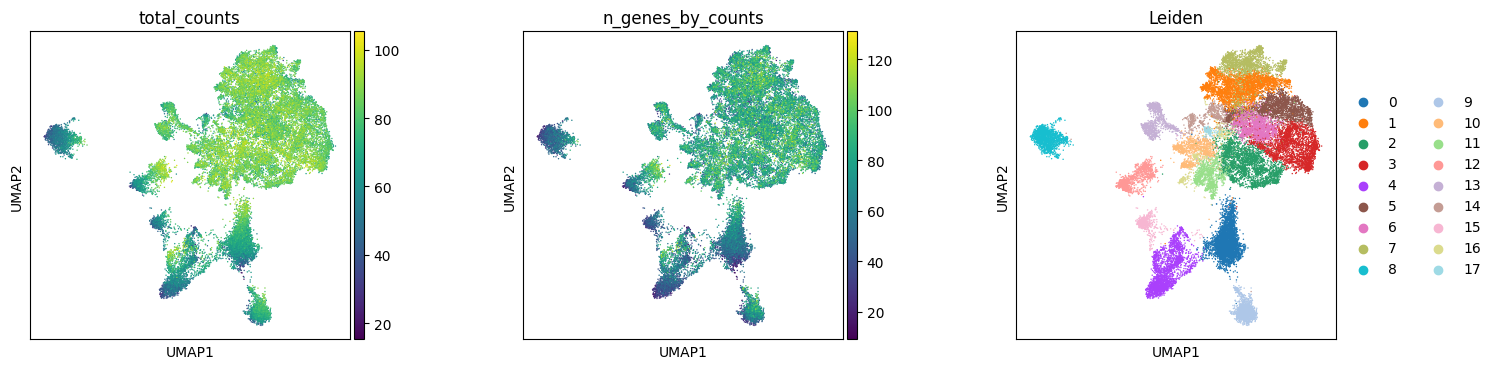

In [45]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata, color=["total_counts", "n_genes_by_counts", "Leiden"], wspace=0.4)

In [ ]:
# saving the adata
adata.write("adata.h5ad")